In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm


import plotly.express as px
import seaborn as sns

import pandas as pd
import numpy as np

import os
from pathlib import Path

In [2]:
production_cap = False
production_suffix = "_capped" if production_cap else "_uncapped"

In [3]:
current_dir = Path.cwd()
print(f"Current working directory:", current_dir)

loss_calculation_folder = current_dir / "evaluation"
print("input files at",loss_calculation_folder)

output_dir = os.path.join(
    loss_calculation_folder,
    "mit_cap" if production_cap else "ohne_cap")
print("output directory at", output_dir)

Current working directory: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project
input files at /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation
output directory at /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/ohne_cap


In [4]:
scenario = ['PAK', 'RUS', 'HOA', 'URU', 'ALL']


df = {}
for s in scenario:

    if production_cap:
        filename = loss_calculation_folder / f"{s}-highestLosses_capped.csv"  
    
    else:
        filename = loss_calculation_folder / f"{s}-highestLosses_no_cap.csv"

    if filename.exists():
        try:
            df[s] = pd.read_csv(filename)
            print(f"✓ Loaded: {filename}")
        except Exception as e:
            print(f"× Error loading {filename}: {str(e)}")
    else:
        print(f"! File not found: {filename}")

✓ Loaded: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/PAK-highestLosses_no_cap.csv
✓ Loaded: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/RUS-highestLosses_no_cap.csv
! File not found: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/HOA-highestLosses_no_cap.csv
! File not found: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/URU-highestLosses_no_cap.csv
✓ Loaded: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/ALL-highestLosses_no_cap.csv


Saved plot: absolute_losses_pak_uncapped.png


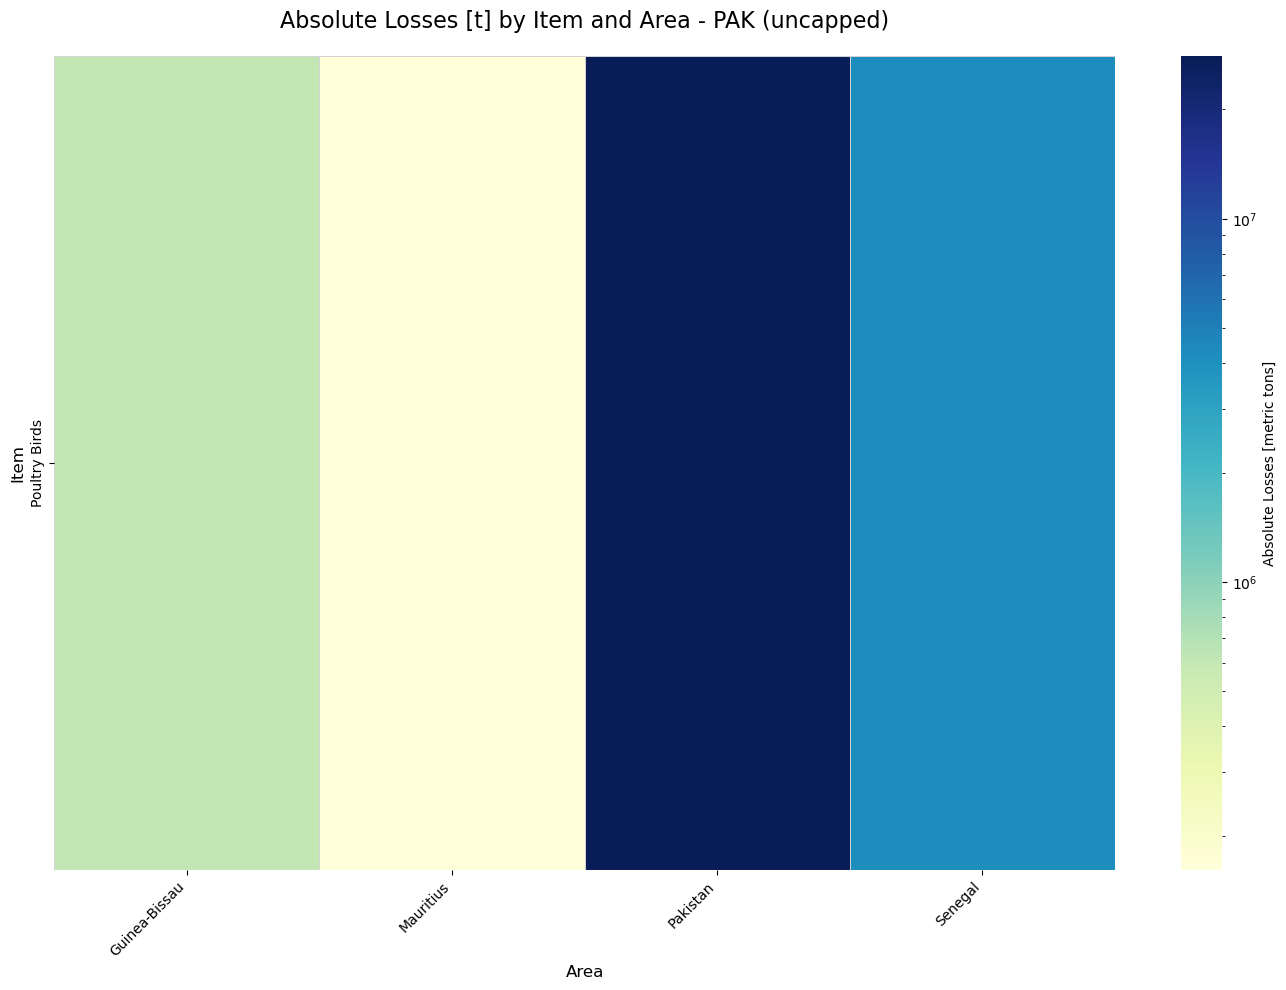

Saved plot: absolute_losses_rus_uncapped.png


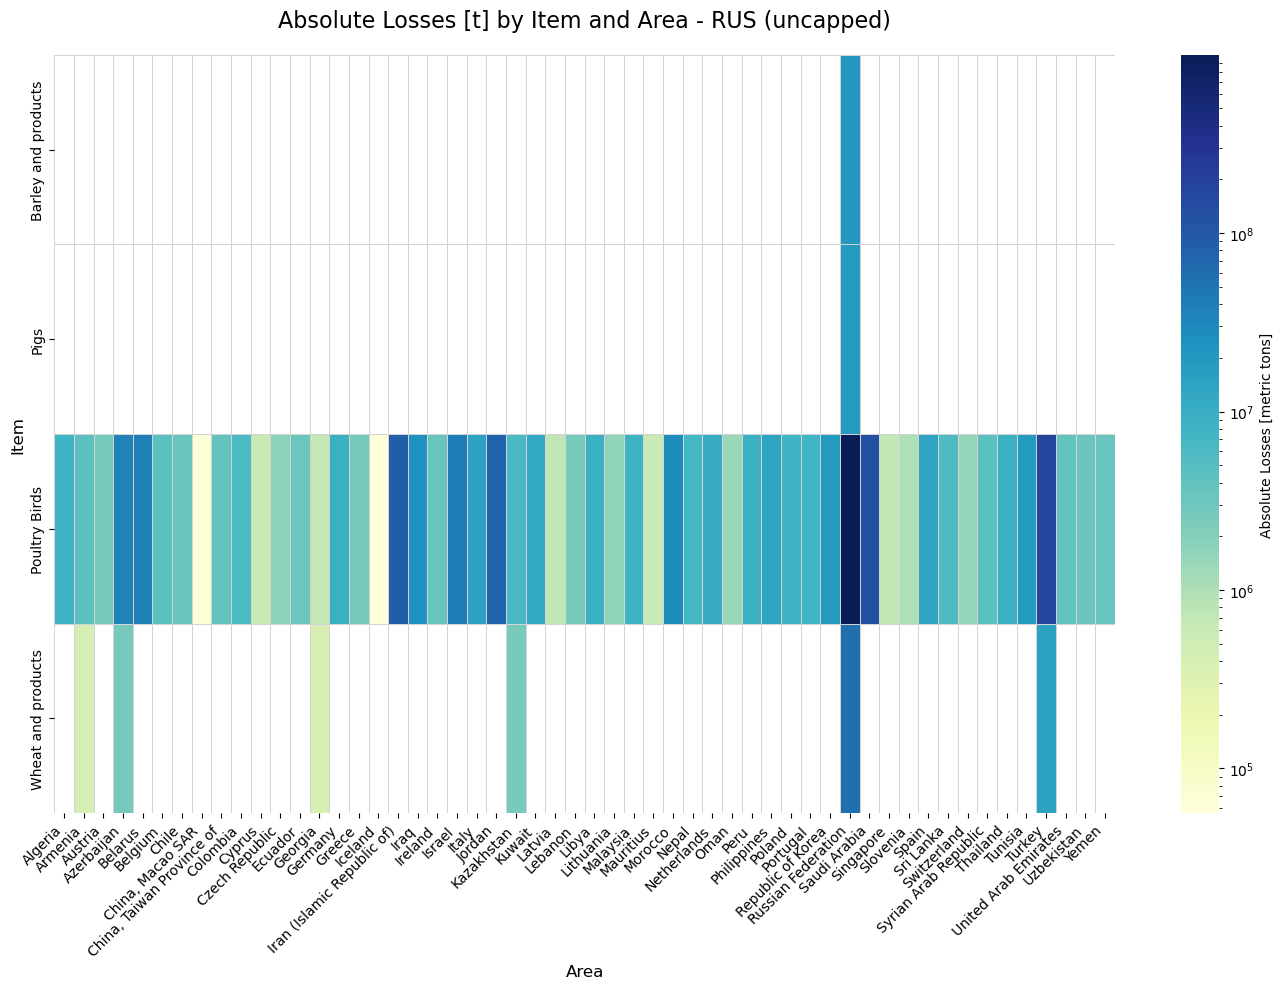

Skipping HOA: scenario not found in data
Skipping URU: scenario not found in data
Saved plot: absolute_losses_all_uncapped.png


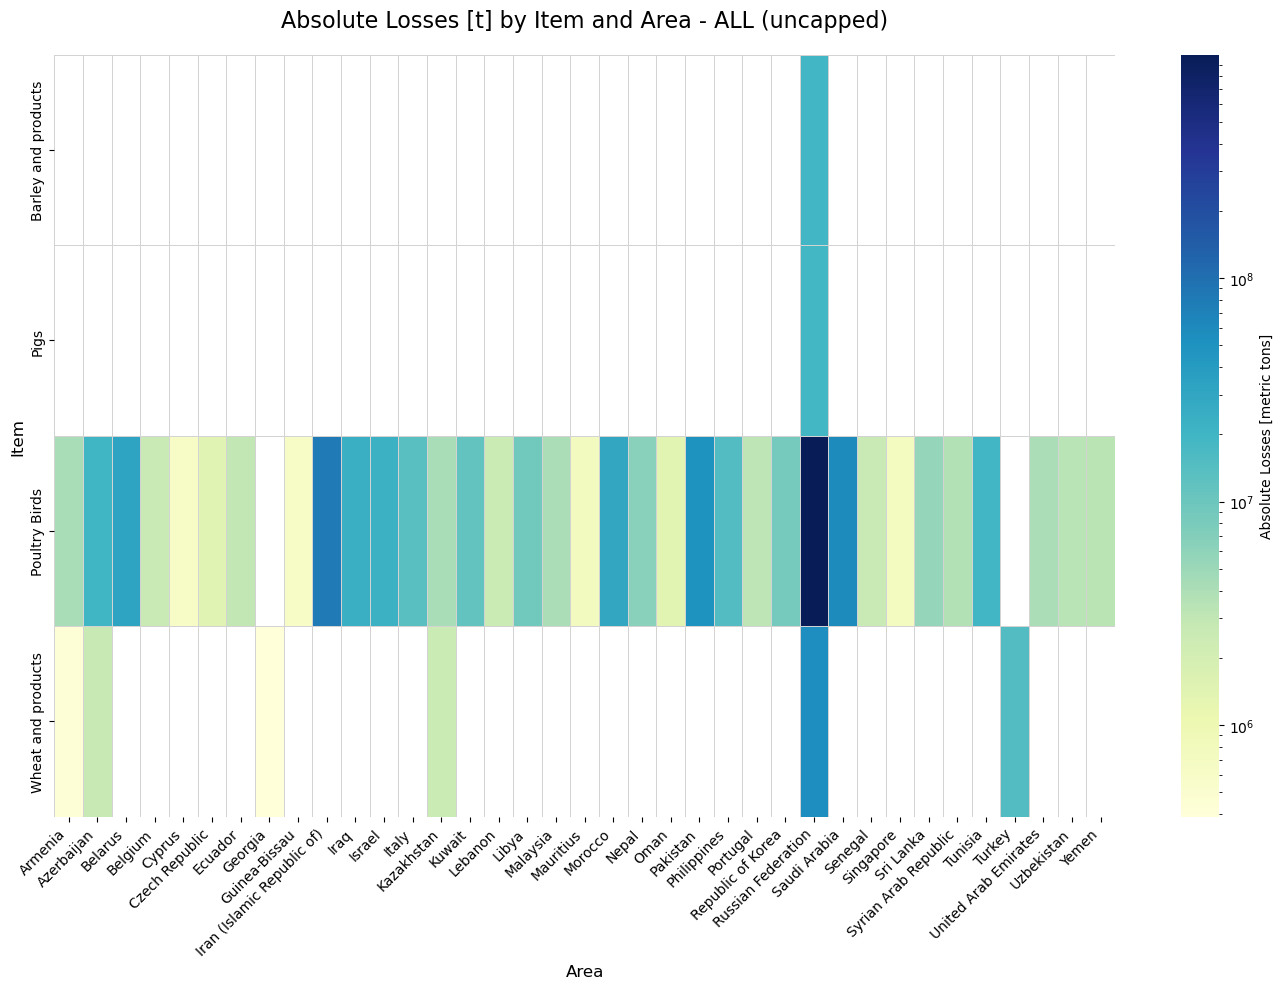

In [5]:
for s in scenario:

    if s not in df:
        print(f"Skipping {s}: scenario not found in data")
        continue

    try:
        # Create pivot table
        pivot_table = df[s].pivot_table(
            index='item',
            columns='area',
            values='absolute_losses [t]',
            aggfunc='sum',
            fill_value=0
        )
    except KeyError as e:
        print(f"Skipping {s}: required column not found - {e}")
        continue

    # Prepare data for plotting
    masked_data = pivot_table.replace(0, np.nan)
    positive_values = masked_data.values.flatten()
    positive_values = positive_values[~np.isnan(positive_values)]

    if len(positive_values) == 0:
        print(f"Skipping {s}: no positive values to plot.")
        continue

    # --- Start of the corrected logic ---
    # Handle the vmin issue for LogNorm by ensuring it's never zero
    min_positive_val = positive_values.min()
    vmin = min_positive_val if min_positive_val > 0 else 1e-6 
    
    vmax = positive_values.max()

    # Set up colormap
    cmap = sns.color_palette("YlGnBu", as_cmap=True)
    cmap.set_bad(color='white')

    # Create title and filename based on the production_cap flag
    if production_cap:
        title = f"Absolute Losses [t] by Item and Area - {s} (capped)"
        status_suffix = "capped"
    else:
        title = f"Absolute Losses [t] by Item and Area - {s} (uncapped)"
        status_suffix = "uncapped"
            
    # The filename and plotting code are now outside the if/else block,
    # ensuring they run in every loop iteration.
    filename = f"absolute_losses_{s.lower()}_{status_suffix}.png"
    plot_path = os.path.join(output_dir, filename)

    # Create and save the plot
    plt.figure(figsize=(14, 10))  # Larger figure for better readability
    ax = sns.heatmap(
        masked_data,
        cmap=cmap,
        # Use the corrected vmin in the normalization
        norm=mcolors.LogNorm(vmin=vmin, vmax=vmax),
        linewidths=0.5,
        linecolor='lightgray',
        # Removed 'format' and will use the LogFormatter for better labels
        cbar_kws={'label': 'Absolute Losses [metric tons]'}
    )
    
    # Get the color bar object and apply a logarithmic formatter for better labels
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.set_major_formatter(mticker.LogFormatterMathtext())

    # Enhanced formatting
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel("Area", fontsize=12)
    plt.ylabel("Item", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Save the main plot
    plt.savefig(plot_path, bbox_inches='tight', dpi=300)
    print(f"Saved plot: {filename}")
    
    # Show and close the plot
    plt.show()
    plt.close()

✓ Saved plot to: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/ohne_cap/relative_losses_pak_uncapped.png


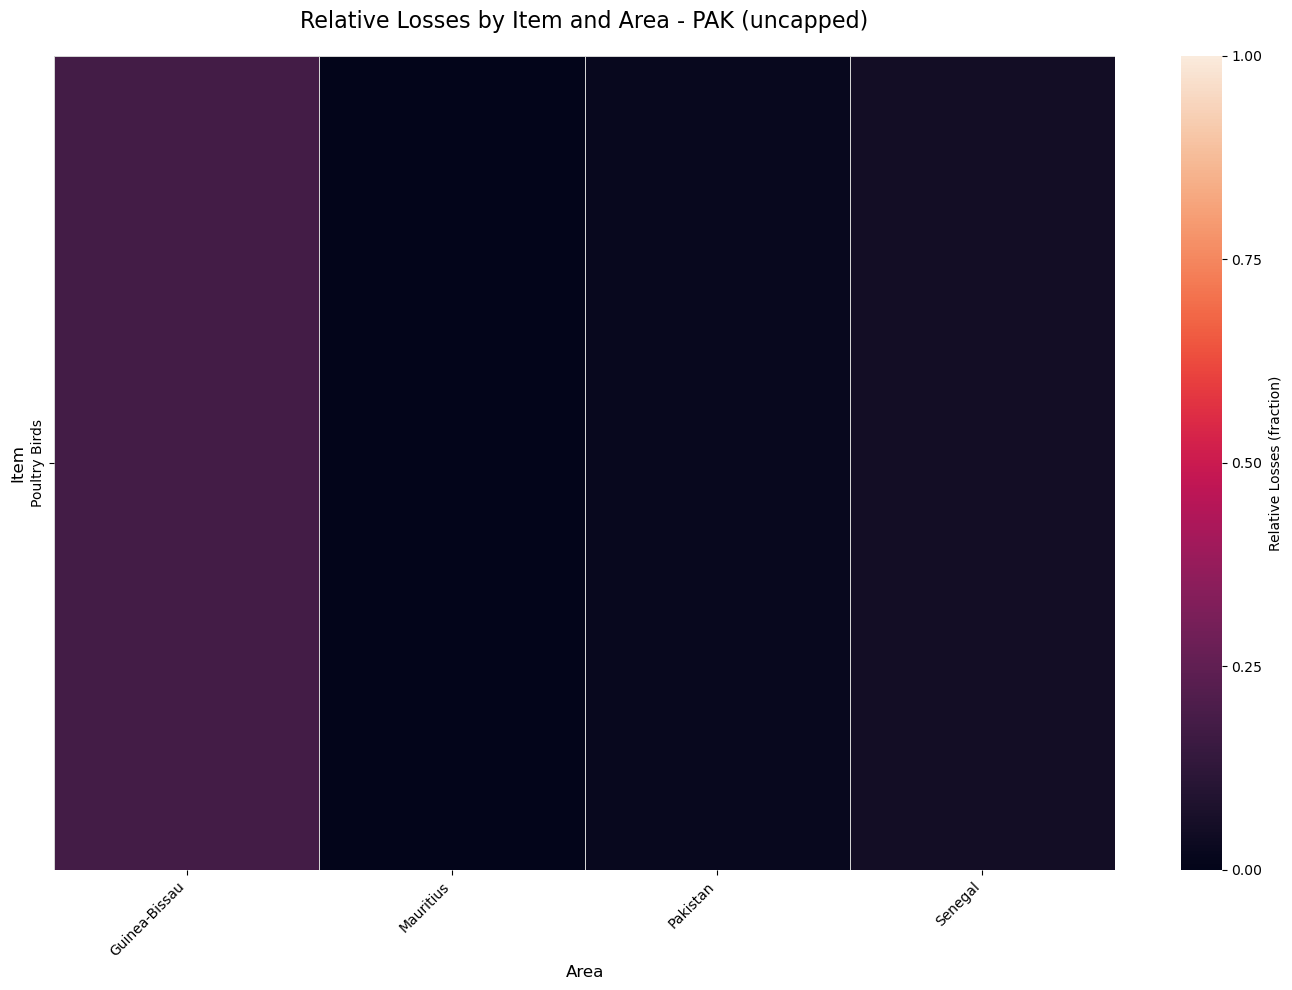

✓ Saved plot to: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/ohne_cap/relative_losses_rus_uncapped.png


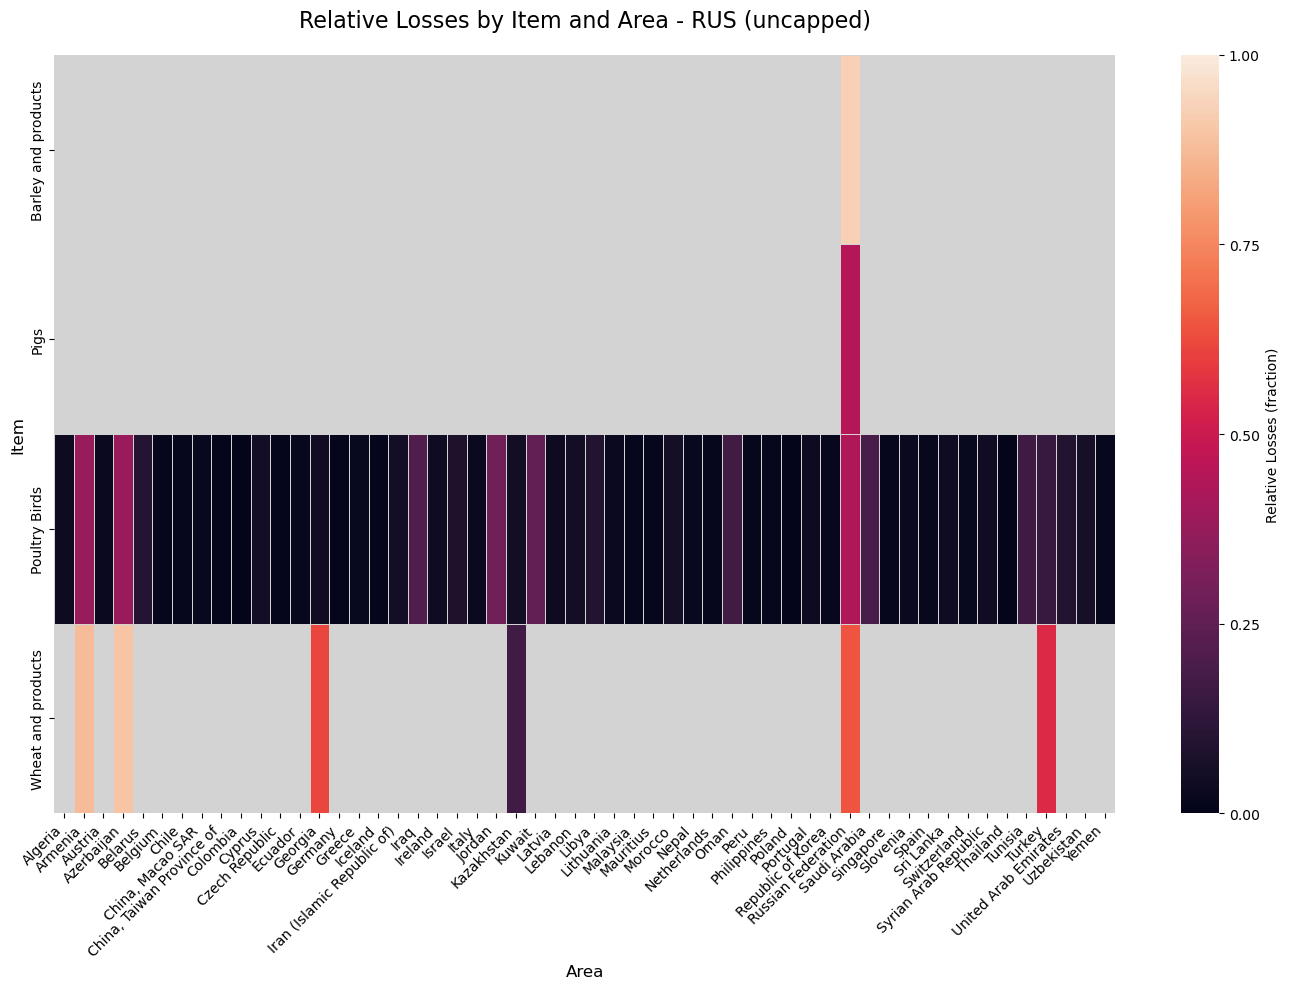

Skipping HOA: scenario not loaded
Skipping URU: scenario not loaded
✓ Saved plot to: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/ohne_cap/relative_losses_all_uncapped.png


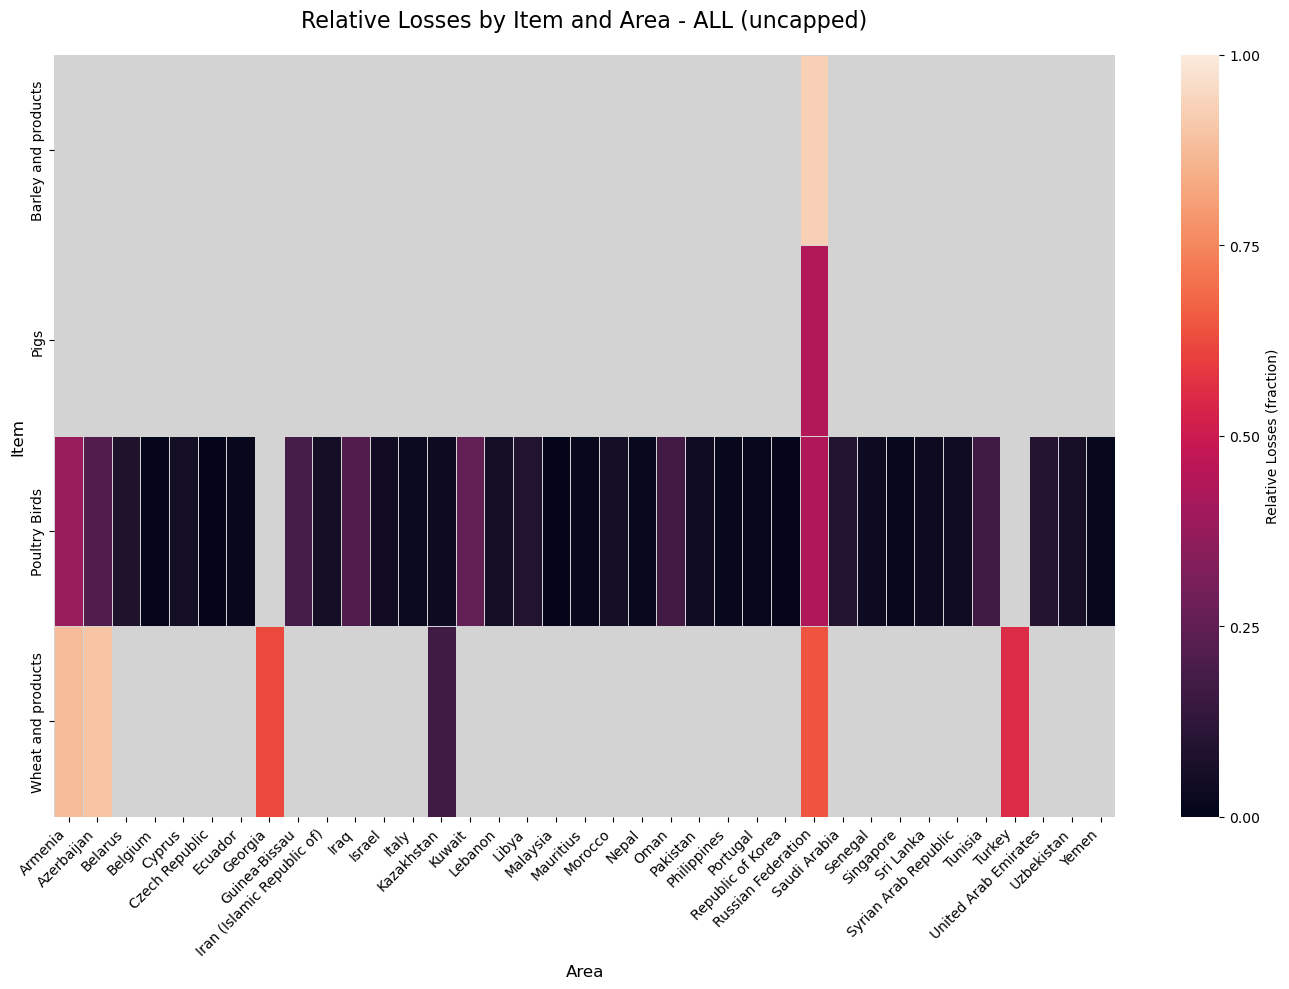

In [6]:
# Your loop should look like this now:
for s in scenario:
    if s not in df:
        print(f"Skipping {s}: scenario not loaded")
        continue

    try:
        # Correct indentation here, so `df_scenario` is part of the try block
        df_scenario = df[s]
        pivot_table = df_scenario.pivot_table(
            index='item',
            columns='area',
            values='relative_losses',
            aggfunc='mean',
            fill_value=0
        )
    except KeyError as e:
        print(f"Skipping {s}: required column not found - {e}")
        continue

    # Replace zeros with NaN (to not skew colors)
    masked_data = pivot_table.replace(0, np.nan)

    if masked_data.isna().all().all():
        print(f"Skipping {s}: all values are zero or NaN.")
        continue

    # Use perceptually uniform colormap and fixed scale
    vmin = 0
    vmax = 1
    cmap = sns.color_palette("rocket", as_cmap=True)  # Better contrast
    cmap.set_bad("lightgray")

    cap_status = "capped" if production_cap else "uncapped"
    title = f"Relative Losses by Item and Area - {s} ({cap_status})"
    filename = f"relative_losses_{s.lower()}_{cap_status}.png"
    plot_path = Path(output_dir) / filename

    plt.figure(figsize=(14, 10))
    sns.heatmap(
        masked_data,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        linewidths=0.5,
        linecolor='lightgray',
        cbar_kws={
            'label': 'Relative Losses (fraction)',
            'ticks': [0, 0.25, 0.5, 0.75, 1],
            'format': '%.2f'
        }
    )

    plt.title(title, fontsize=16, pad=20)
    plt.xlabel("Area", fontsize=12)
    plt.ylabel("Item", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    plt.savefig(plot_path, bbox_inches='tight', dpi=300)
    print(f"✓ Saved plot to: {plot_path}")
    plt.show()
    plt.close()

Saved plot to: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/ohne_cap/per_capita_losses_kg_pak_uncapped.png


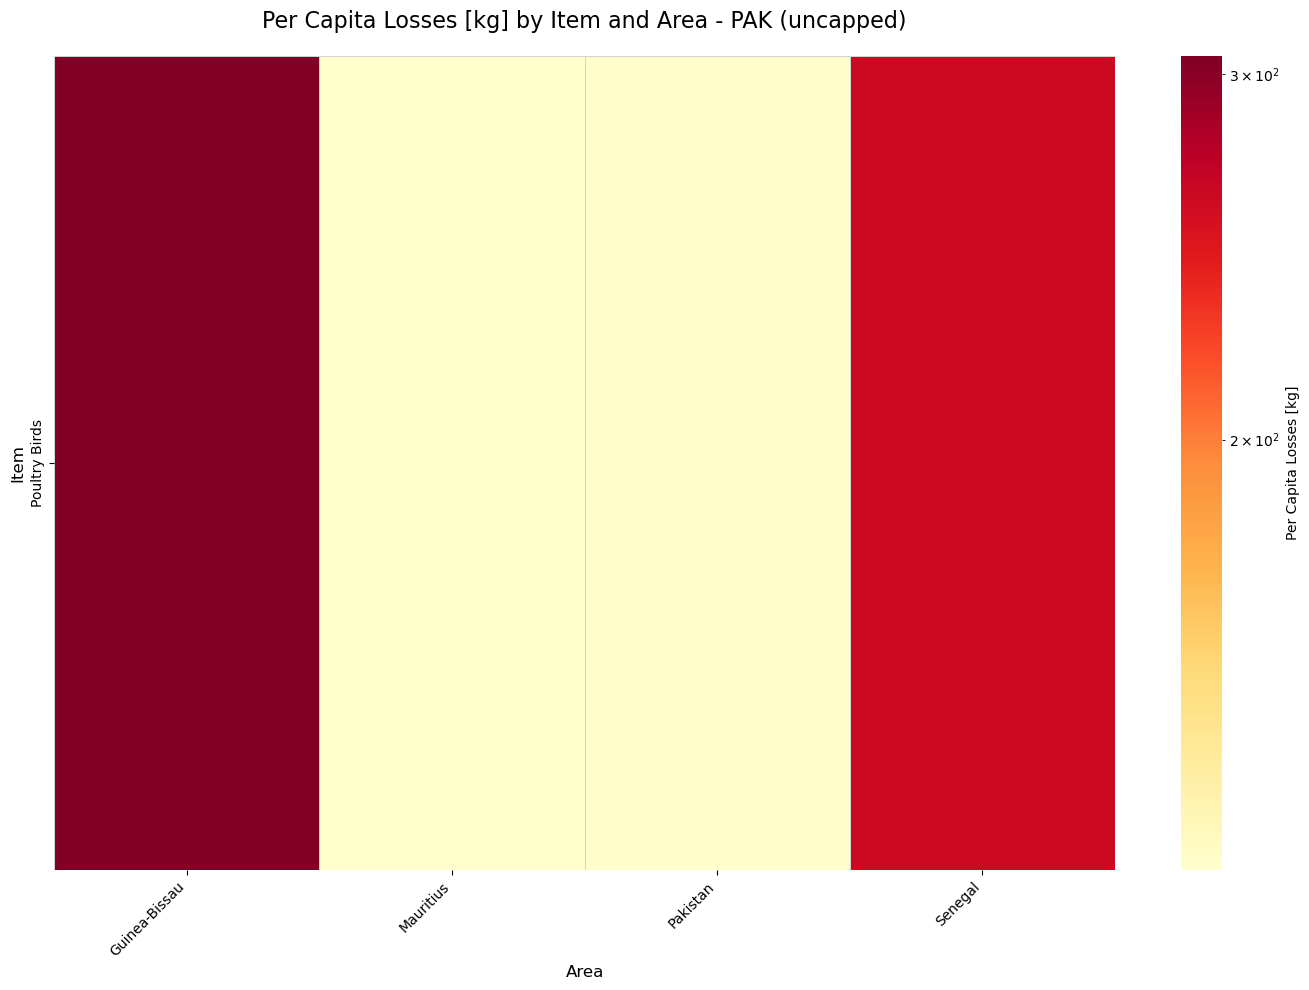

Saved plot to: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/ohne_cap/per_capita_losses_kg_rus_uncapped.png


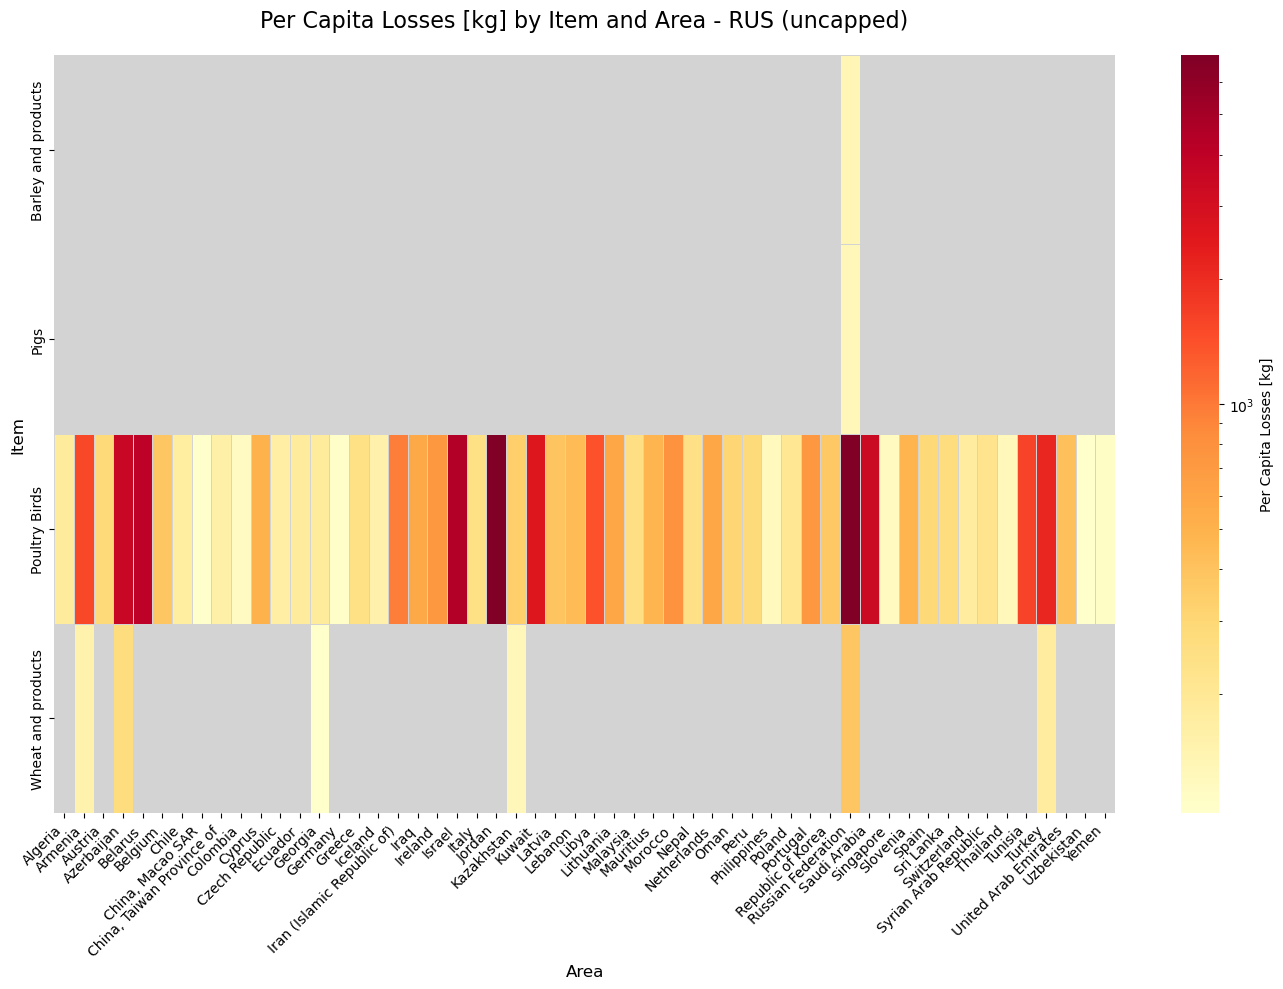

Skipping HOA: scenario not found in data
Skipping URU: scenario not found in data
Saved plot to: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/ohne_cap/per_capita_losses_kg_all_uncapped.png


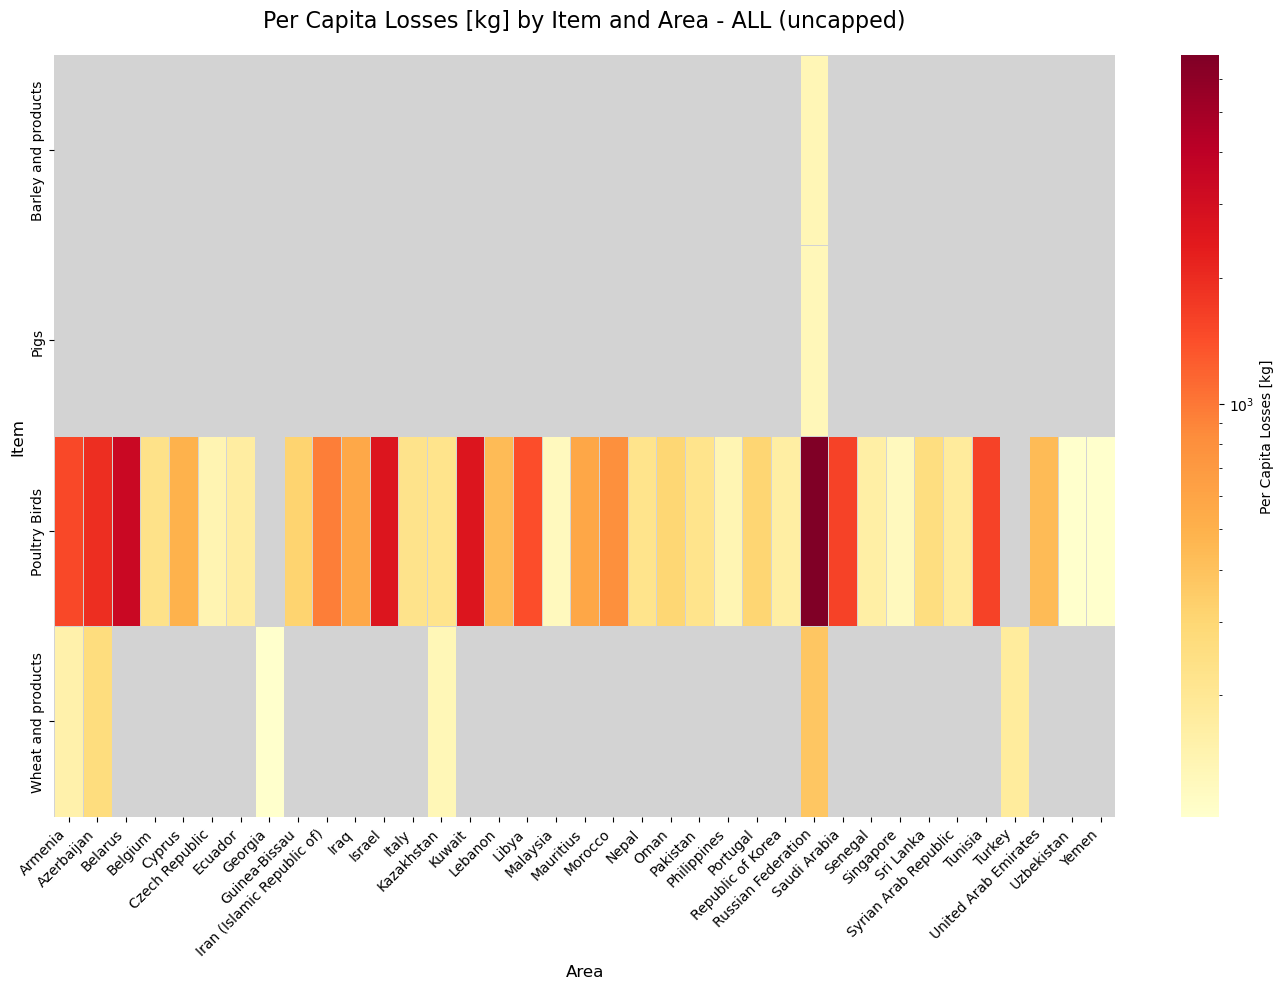

In [7]:
for s in scenario:
    # Skip if scenario not in data
    if s not in df:
        print(f"Skipping {s}: scenario not found in data")
        continue
        
    try:
        # Create pivot table for per capita losses
        pivot_table = df[s].pivot_table(
            index='item',
            columns='area',
            values='al/capita [kg]',  # Using per capita losses
            aggfunc='sum',            # Summing kg losses across categories
            fill_value=0
        )
    except KeyError as e:
        print(f"Skipping {s}: required column not found - {e}")
        continue

    # Prepare data for plotting
    masked_data = pivot_table.replace(0, np.nan)
    valid_values = masked_data.values.flatten()
    valid_values = valid_values[~np.isnan(valid_values)]

    if len(valid_values) == 0:
        print(f"Skipping {s}: no valid values to plot.")
        continue

    # Set visualization parameters
    vmin = max(valid_values.min(), 0.1)  # Minimum 0.1 kg for visualization
    vmax = valid_values.max()
    
    # Using sequential colormap for absolute losses
    cmap = sns.color_palette("YlOrRd", as_cmap=True)  
    cmap.set_bad(color='lightgray')

    # Create title and filename
    cap_status = "capped" if production_cap else "uncapped"
    title = f"Per Capita Losses [kg] by Item and Area - {s} ({cap_status})"
    filename = f"per_capita_losses_kg_{s.lower()}_{cap_status}.png"
    plot_path = Path(output_dir) / filename

    # Create plot with logarithmic scale
    plt.figure(figsize=(14, 10))
    ax = sns.heatmap(
        masked_data,
        cmap=cmap,
        norm=mcolors.LogNorm(vmin=vmin, vmax=vmax),  # Log scale for wide ranges
        linewidths=0.5,
        linecolor='lightgray',
        cbar_kws={
            'label': 'Per Capita Losses [kg]', 
        }
    )

    # Get the color bar object and apply a logarithmic formatter for better labels
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.set_major_formatter(mticker.LogFormatterMathtext())

    # Formatting
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel("Area", fontsize=12)
    plt.ylabel("Item", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Save plot
    plt.savefig(plot_path, bbox_inches='tight', dpi=300)
    print(f"Saved plot to: {plot_path}")
    plt.show()
    plt.close()

# Absolute Profits

In [8]:
df = {}
for s in scenario:

    if production_cap:
        filename = loss_calculation_folder / f"{s}-highestProfits_capped.csv"  
    
    else:
        filename = loss_calculation_folder / f"{s}-highestProfits_no_cap.csv"

    if filename.exists():
        try:
            df[s] = pd.read_csv(filename)
            print(f"✓ Loaded: {filename}")
        except Exception as e:
            print(f"× Error loading {filename}: {str(e)}")
    else:
        print(f"! File not found: {filename}")

! File not found: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/PAK-highestProfits_no_cap.csv
✓ Loaded: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/RUS-highestProfits_no_cap.csv
✓ Loaded: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/HOA-highestProfits_no_cap.csv
✓ Loaded: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/URU-highestProfits_no_cap.csv
✓ Loaded: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/ALL-highestProfits_no_cap.csv


Skipping PAK: no data loaded.
Saved plot: per_capita_losses_kg_rus_uncapped.png


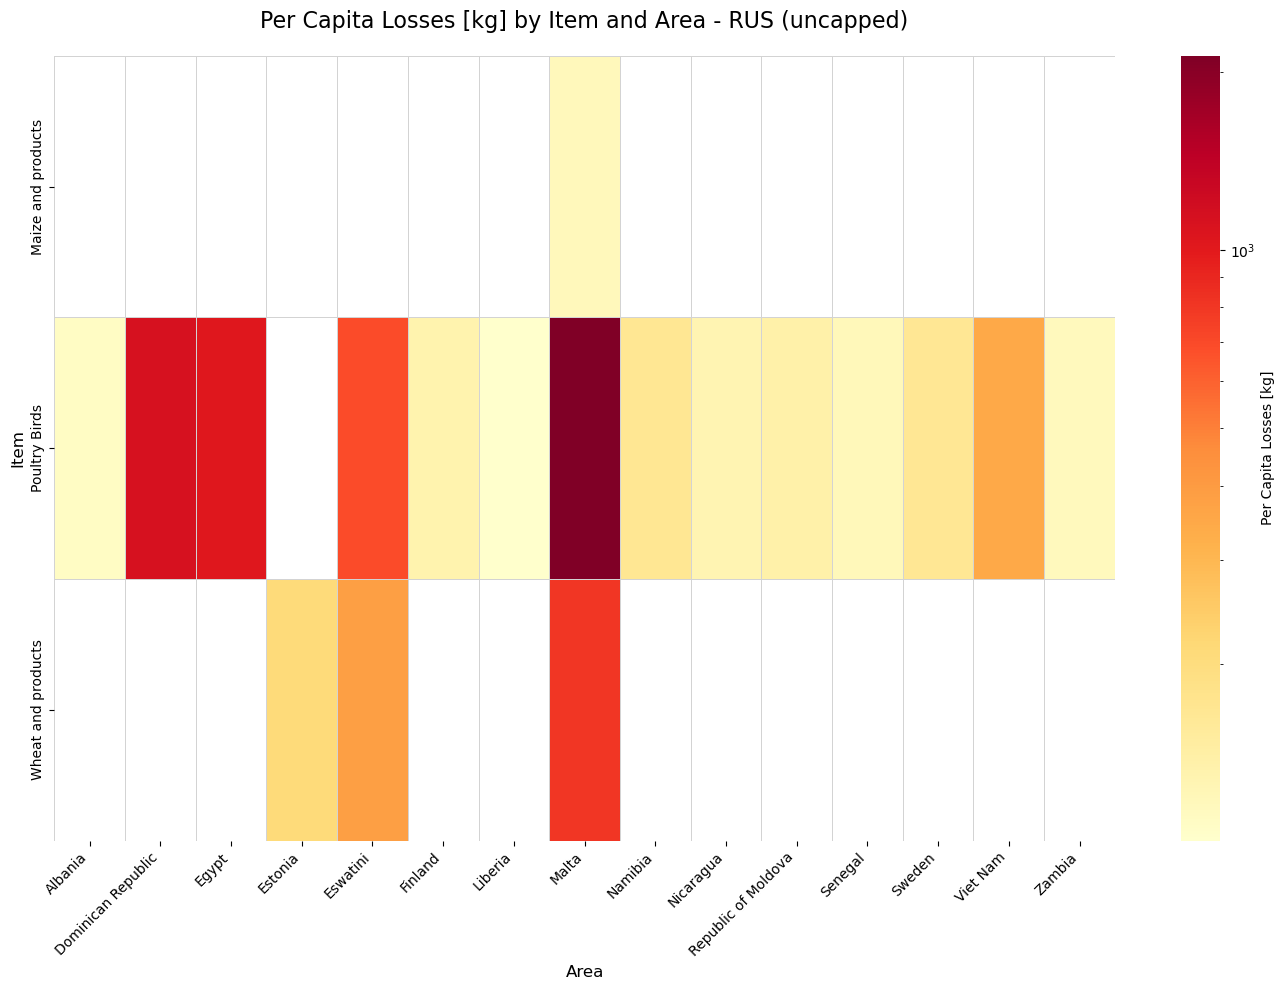

Saved plot: per_capita_losses_kg_hoa_uncapped.png


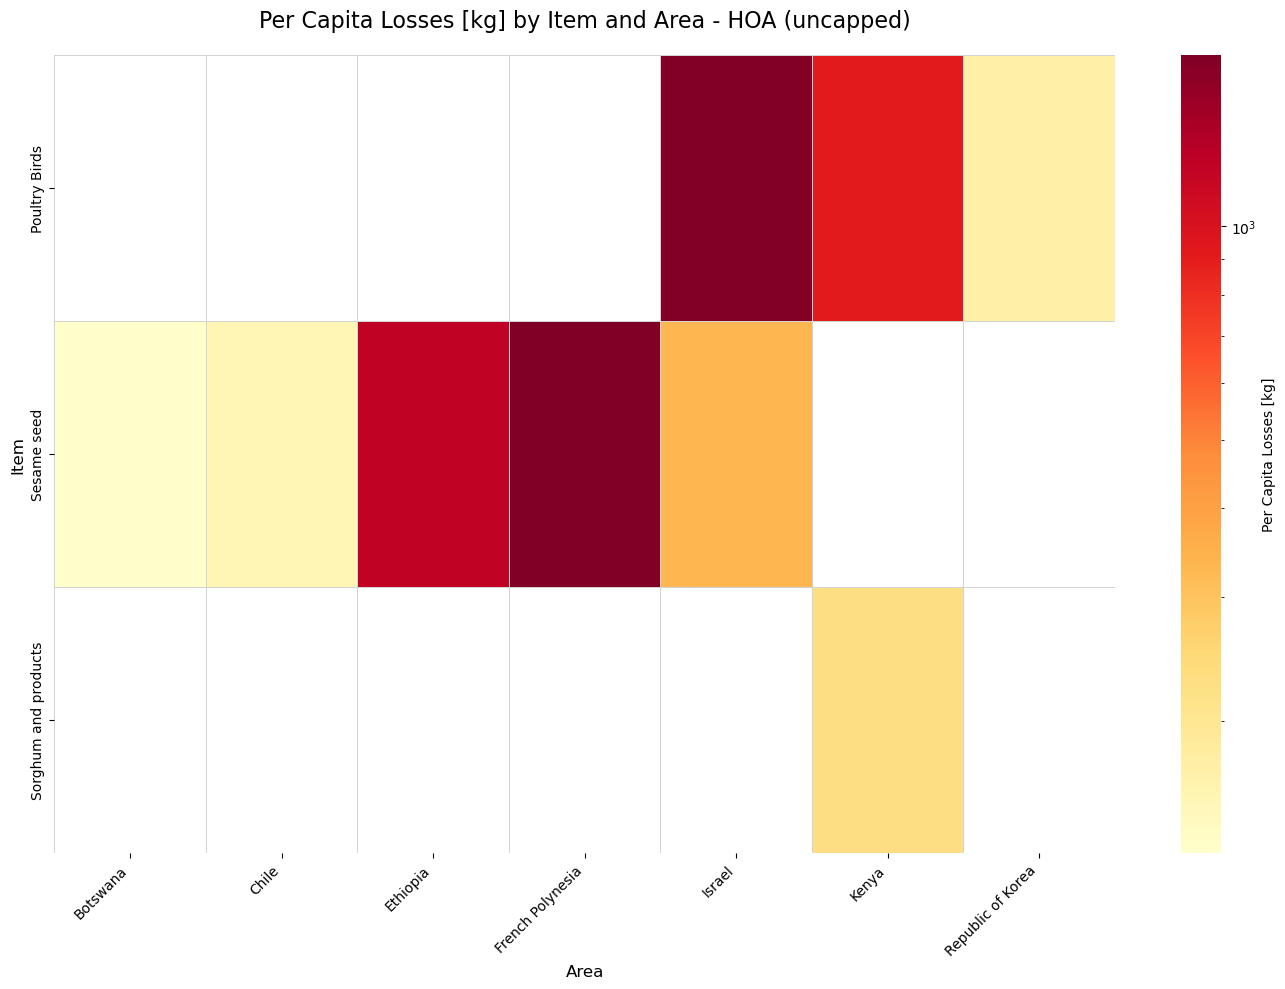

Saved plot: per_capita_losses_kg_uru_uncapped.png


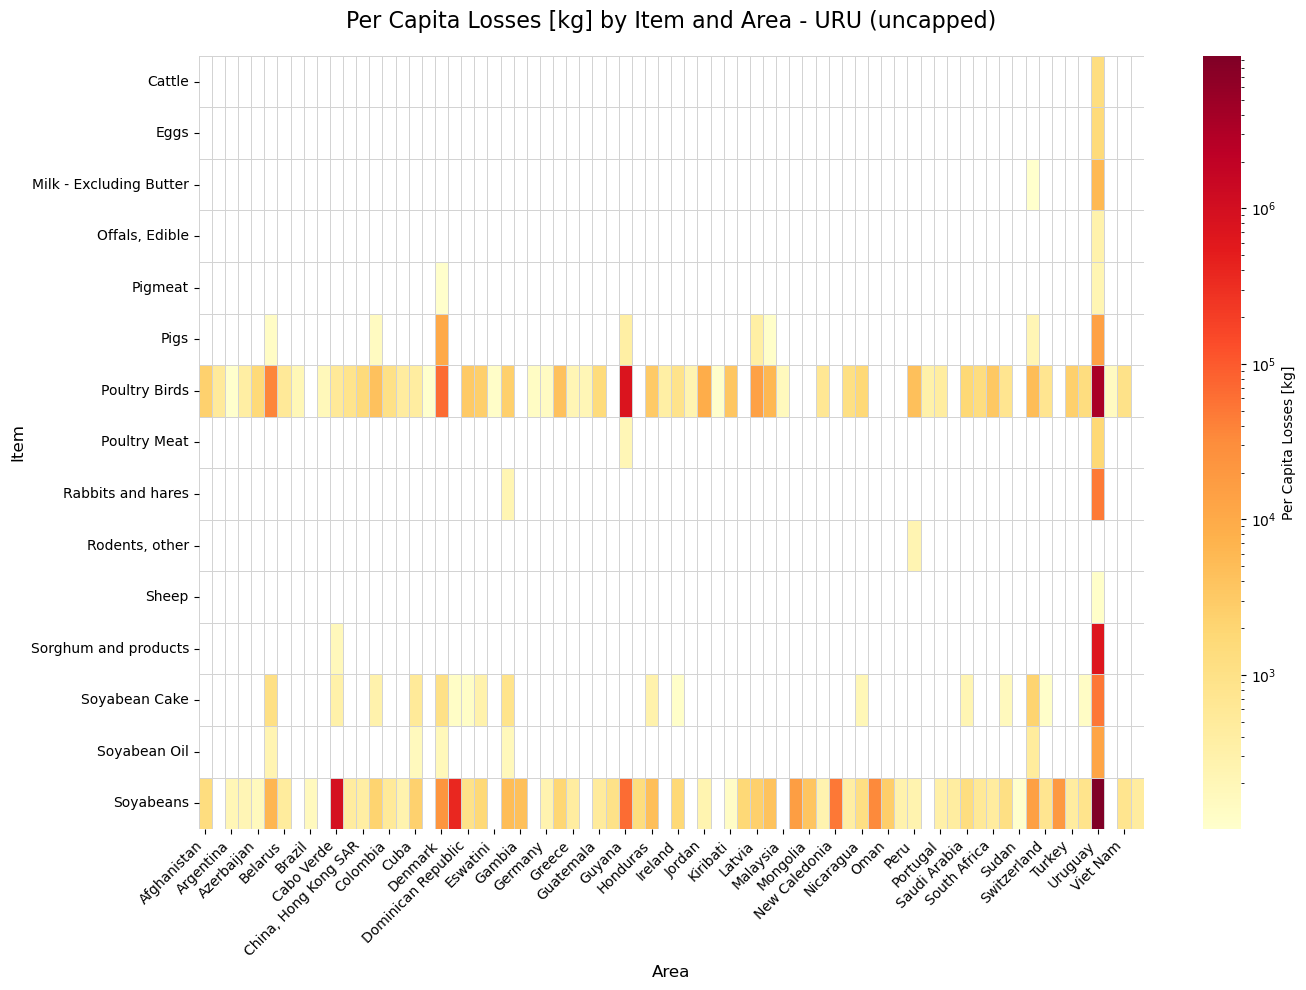

Saved plot: per_capita_losses_kg_all_uncapped.png


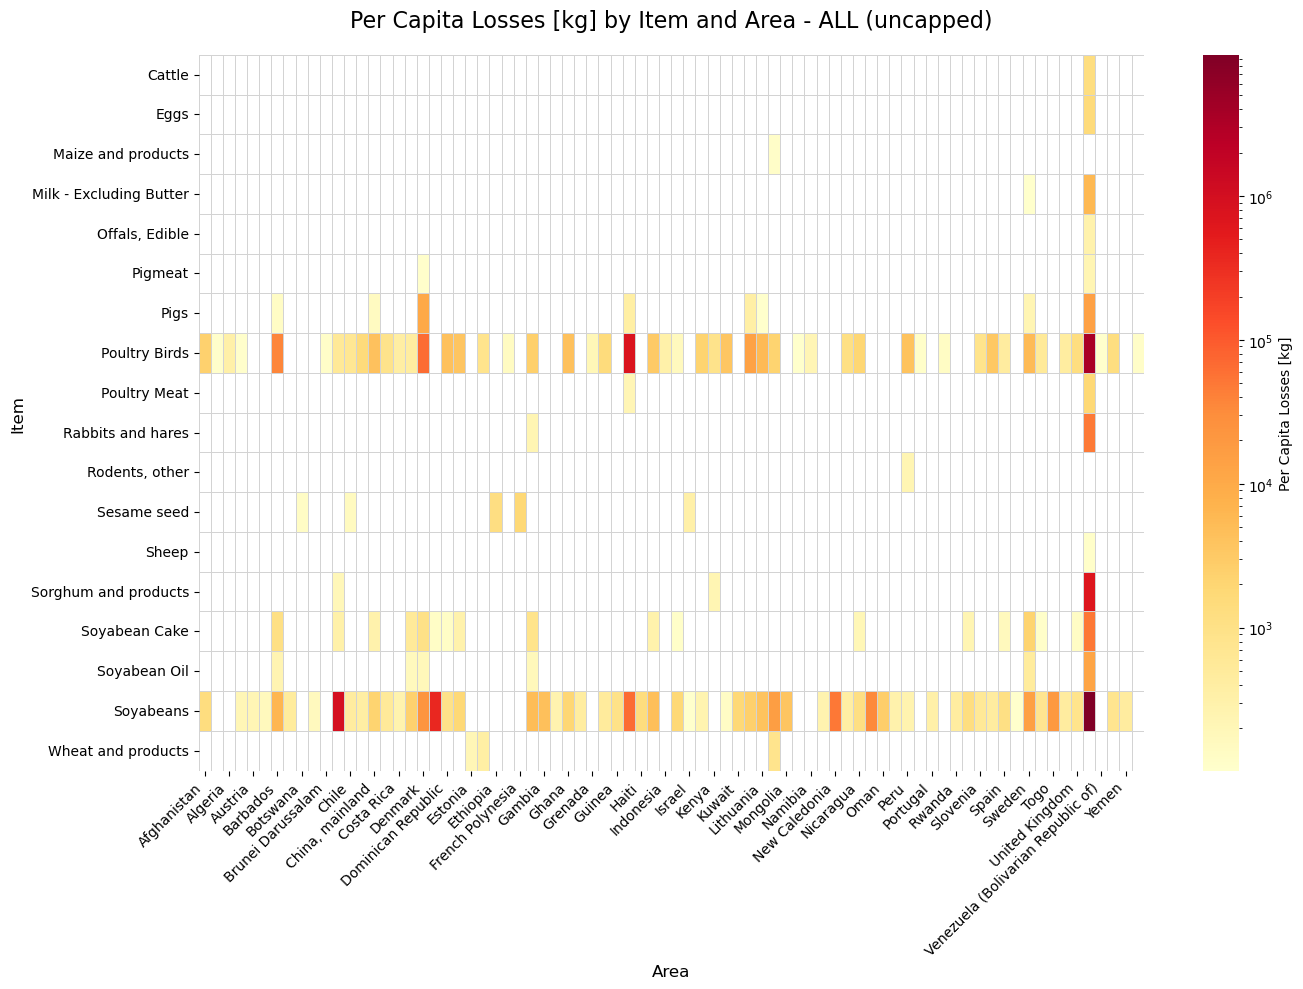

In [9]:
for s in scenario:
    # Skip if scenario not in data
    if s not in df:
        print(f"Skipping {s}: no data loaded.")
        continue

    # Create pivot table
    try:
        pivot_table = df[s].pivot_table(
            index='item',
            columns='area',
            values='al/capita [kg]',
            aggfunc='sum',
            fill_value=0
        ).abs()
    except KeyError as e:
        print(f"Skipping {s}: missing required column - {e}")
        continue

    # Mask zero values
    masked_data = pivot_table.replace(0, np.nan)
    
    # Skip if no valid data
    if masked_data.isna().all().all():
        print(f"Skipping {s}: no valid data to plot.")
        continue

    # Get positive values for scaling
    positive_values = masked_data.values[~np.isnan(masked_data.values)]
    if len(positive_values) == 0:
        print(f"Skipping {s}: no positive values found.")
        continue

    # Set color scale
    vmin = max(positive_values.min(), 1e-3)
    vmax = positive_values.max()
    if vmin >= vmax:
        vmax = vmin * 10

    # Create title and filename
    cap_status = "capped" if production_cap else "uncapped"
    # Corrected title and filename to match the column being plotted
    title = f"Per Capita Losses [kg] by Item and Area - {s} ({cap_status})"
    filename = f"per_capita_losses_kg_{s.lower()}_{cap_status}.png"
    plot_path = Path(output_dir) / filename

    # Create and save the plot
    plt.figure(figsize=(14, 10))  # Larger figure for better readability
    ax = sns.heatmap(
        masked_data,
        cmap=sns.color_palette("YlOrRd", as_cmap=True),
        norm=mcolors.LogNorm(vmin=vmin, vmax=vmax),
        linewidths=0.5,
        linecolor='lightgray',
        # Corrected color bar label to match the column being plotted
        cbar_kws={'label': 'Per Capita Losses [kg]'}
    )

    # Use the appropriate logarithmic formatter
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.set_major_formatter(mticker.LogFormatterMathtext())

    # Enhanced formatting
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel("Area", fontsize=12)
    plt.ylabel("Item", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Save the main plot
    plt.savefig(plot_path, bbox_inches='tight', dpi=300)
    print(f"Saved plot: {filename}")
    plt.show()
    plt.close()